<a href="https://colab.research.google.com/github/prasanth5reddy/D2L/blob/master/Multilayer%20Perceptrons/weight_decay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab/D2L.AI/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing Libraries

In [2]:
!pip install mxnet

Importing Libraries

In [0]:
%matplotlib inline
import d2l, time
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

Generate the Data

In [0]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

Implementation from scratch

Initialize Model Parameters

In [0]:
def init_params():
  w = nd.random.normal(scale=1, shape=(num_inputs, 1))
  b = nd.zeros(shape=(1,))
  w.attach_grad()
  b.attach_grad()
  return [w, b]

Define L2 Norm Penalty

In [0]:
def l2_penalty(w):
  return (w ** 2).sum() / 2

Define Training and Testing

In [0]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)

def fit_and_plot(lambd):
  w, b = init_params()
  train_ls, test_ls = [], []
  
  for _ in range(num_epochs):
    for X, y in train_iter:
      with autograd.record():
        l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
      l.backward()
      
      d2l.sgd([w, b], lr, batch_size)
      
    train_ls.append(loss(net(train_features, w, b), train_labels).mean().asscalar())
    test_ls.append(loss(net(test_features, w, b), test_labels).mean().asscalar())
  
  d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])
  print('L2 norm of w:', w.norm().asscalar())

Training without Regularization

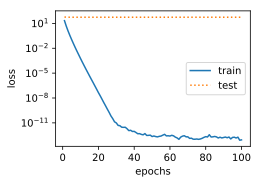

L2 norm of w: 11.611942


In [8]:
fit_and_plot(lambd=0)

Using Weight Decay

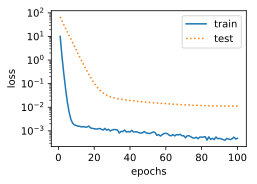

L2 norm of w: 0.041449483


In [9]:
fit_and_plot(lambd=3)

Concise Implementation

In [0]:
def fit_and_plot_gluon(wd):
  net = nn.Sequential()
  net.add(nn.Dense(1))
  net.initialize(init.Normal(sigma=1))
  
  loss = gloss.L2Loss()
  
  # The weight parameter has been decayed. Weight names generally end with weight
  trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', {'learning_rate': lr, 'wd': wd})
  # The bias parameter has not decayed. Bias names generally end with "bias"
  trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd', {'learning_rate': lr}) 
  
  train_ls, test_ls = [], []
  
  for _ in range(num_epochs):
    for X, y in train_iter:
      with autograd.record():
        l = loss(net(X), y)
      l.backward()
      
      # Call the step function on each of the two Trainer instances to update the weight and bias separately
      trainer_w.step(batch_size)
      trainer_b.step(batch_size)
      
    train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
    test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
  
  d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])
  print('L2 norm of w:', net[0].weight.data().norm().asscalar())

Without Regularization

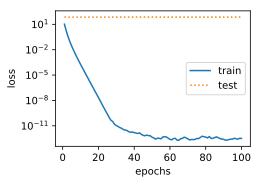

L2 norm of w: 13.311796


In [11]:
fit_and_plot_gluon(0)

Using Weight Decay

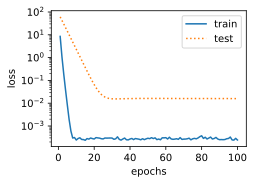

L2 norm of w: 0.033290826


In [12]:
fit_and_plot_gluon(3)